In [ ]:
# For mac OS
# %pip install -U tensorflow==2.16.2 tensorflow-macos==2.16.2 keras==3.4.1 keras-nlp
# For AWS SageMaker
# %pip install -U tensorflow==2.16.2 tensorflow-datasets keras==3.4.1 keras-nlp datasets

In [1]:
import tensorflow as tf
import keras
import keras_nlp
print("Tensorflow 2.16.2 is expected. The running version is", tf.__version__)
print("Keras 3.4.1 is expected. The running version is", keras.__version__)
print("KerasNLP 0.12.1 is expected. The running version is", keras_nlp.__version__)

import numpy as np
import tensorflow_datasets as tfds
# SageMaker cannot use @keras.saving
from keras import saving

Tensorflow 2.16.2 is expected. The running version is 2.16.2
Keras 3.4.1 is expected. The running version is 3.4.1
KerasNLP 0.12.1 is expected. The running version is 0.12.1


# Utility function

In [2]:
import platform

def is_running_on_apple_sillicon():
    return platform.system() == "Darwin" and platform.processor() == "arm"

DEVELOPMENT = is_running_on_apple_sillicon()

In [3]:
import matplotlib.pyplot as plt

def plot(history, title=None, keys=["loss", "masked_acc"]):
    """
    Display the plot that indicates the loss and accuracy.
    :param history: history object from the tensorflow fit function.
    :param title: title text.
    :param keys: keys for plotting.
    """
    flg, axes = plt.subplots(1, 2, tight_layout=True)
    if title is not None:
        flg.suptitle(t=title, fontsize=14)
    for i, key in enumerate(keys):
        value = history.history[key]
        val_loss = history.history[f"val_{key}"]
        epochs = range(1, len(value) + 1)
        axes[i].plot(epochs, value, label=f"Training {key}")
        axes[i].plot(epochs, val_loss, label=f"Validation {key}")
        axes[i].set_title(f"Training and validation {key}")
        axes[i].set_xlabel("epochs")
        axes[i].set_ylabel(key)
        axes[i].legend()
    plt.show()

    for key in keys:
        if 'loss' in key:
            print(
                np.min(history.history[f"val_{key}"]),
                "The best number of epocs for the validation loss is",
                np.argmin(history.history[f"val_{key}"]) + 1,
            )
        else:
            print(
                np.max(history.history[f"val_{key}"]),
                "The best number of epocs for the validation accuracy is",
                np.argmax(history.history[f"val_{key}"]) + 1,
            )

In [4]:
# @see https://github.com/keras-team/keras-nlp/blob/50e041487b1d8b30b34c5fb738db3ed3406363bc/examples/machine_translation/data.py
import string
import re

strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

@saving.register_keras_serializable()
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase,
        "[%s]" % re.escape(strip_chars),
        "",
    )

In [5]:
"""
### The reason why the masked loss is required for seq2seq models

The prediction y values of seq2seq models contain pad(s), which are used to align the length of every output sequence.
In the case that most sequences are much shorter than the longest sentence and pads are not considered,
a model that predicts only pads of sentences is highly evaluated.
Therefore, excluding pads from the loss calculation improves the model.

### The reason why the classification model does not use the masked loss function

The prediction y values of classification models do not contain pad(s), which are used to align the length of every output sequence.
It just contains the probability of each class.
"""

# @see https://www.tensorflow.org/text/tutorials/nmt_with_attention
@saving.register_keras_serializable()
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = keras.losses.SparseCategoricalCrossentropy(
        # nn.py:609: UserWarning:
        # "`sparse_categorical_crossentropy` received `from_logits=True`,
        # but the `output` argument was produced by a Softmax activation and thus does not represent logits.
        # Was this intended?
        # When logits is True, softmax activation function has not processed the values.
        # from_logits=True,
        reduction='none'
    )
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, dtype=loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [6]:
# @see https://www.tensorflow.org/text/tutorials/nmt_with_attention
# def masked_acc(y_true, y_pred):
#     # Calculate the loss for each item in the batch.
#     y_pred = tf.argmax(y_pred, axis=-1)
#     y_pred = tf.cast(y_pred, dtype=y_true.dtype)
#     match = tf.cast(y_true == y_pred, dtype=tf.float32)
#     mask = tf.cast(y_true != 0, dtype=tf.float32)
#     return tf.reduce_sum(match)/tf.reduce_sum(mask)

# @see https://www.tensorflow.org/text/tutorials/transformer
@saving.register_keras_serializable()
def masked_acc(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=2)
    y_true = tf.cast(y_true, dtype=y_pred.dtype)
    match = y_true == y_pred
    mask = y_true != 0
    match = match & mask
    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

## Dataset

In [7]:
def prepare_datasets():
    if is_running_on_apple_sillicon():
        args = {
            'trust_remote_code': False,
        }
    else:
        """
        When 'trust_remote_code' is False, it does not work on AWS SageMaker.
        """
        args = {
        }
    train_ds, validation_ds, test_ds = tfds.load(
        'huggingface:ccdv__cnn_dailymail/3.0.0',
        split=['train', 'validation', 'test'],
        builder_kwargs=args,
    )
    # for development with 1/10 entries
    if DEVELOPMENT:
        train_size = len(train_ds) // 10 * 9
        validation_size = len(validation_ds) // 10 * 9
        test_size = len(test_ds) // 10 * 9
        train_ds = train_ds.skip(train_size)
        validation_ds = validation_ds.skip(validation_size)
        test_ds = test_ds.skip(test_size)
    return train_ds, validation_ds, test_ds

In [8]:
def prepare_tokenizer(
        train_ds,
        encoder_sequence_length,
        decoder_sequence_length,
        max_tokens=15000):
    """
    Display the plot that indicates the loss and accuracy.
    :param train_ds: training dataset to obtain vocabulary.
    :param max_tokens: In other words, this is the vocabulary size.
    :param encoder_sequence_length: The sequence length for input.
    :param input_output_sequence_length: The sequence length for target.
    """
    vectorization_layer = keras.layers.TextVectorization(
        standardize=custom_standardization,
        max_tokens=max_tokens,
        output_mode='int',
        ragged=True,
    )
    # Warning: adapt, which clear the already held data inside, must be called only once.
    vectorization_layer.adapt(train_ds.map(lambda row: '[start] ' + row['article'] + ' ' + row['highlights'] + ' [end]'))
    vocabulary = vectorization_layer.get_vocabulary()

    input_vectorization_layer = keras.layers.TextVectorization(
        standardize=custom_standardization,
        max_tokens=max_tokens,
        output_mode='int',
        output_sequence_length=encoder_sequence_length,
    )
    target_vectorization_layer = keras.layers.TextVectorization(
        standardize=custom_standardization,
        max_tokens=max_tokens,
        output_mode='int',
        output_sequence_length=decoder_sequence_length,
    )
    input_vectorization_layer.set_vocabulary(vocabulary)
    target_vectorization_layer.set_vocabulary(vocabulary)
    return vectorization_layer, input_vectorization_layer, target_vectorization_layer

def build_datasets(
        train_ds, validation_ds, test_ds,
        input_vectorization_layer,
        vectorization_layer,
        batch_size,
        encoder_sequence_length,
        decoder_sequence_length):
    """
    vectorization_layer(['This is a pen', 'I am a software engineer'])
    #vectorization_layer(['This is a pen', 'I am a software engineer']).row_lengths().shape[0]
    # 2
    rows = vectorization_layer(['This is a pen', 'I am a software engineer']).row_lengths().shape[0]
    vectorization_layer(['This is a pen', 'I am a software engineer']).to_tensor(shape=(rows, 10))
    # .to_tensor()

    RaggedTensor.to_tensor can make 0-filled Tensor
    """
    def format_dataset(x):
        # decoder_sequence_length: either the following 2.
        # - decoder input: [start] + sentence
        # - decoder output: sentence + [end]
        # That is, decoder_sequence_length = sentence length + 1
        summarized_text_length = decoder_sequence_length - 1
        article = input_vectorization_layer(x['article'])
        highlights = tf.strings.join(['[start] ', x['highlights'], ' [end]'])
        h = vectorization_layer(highlights)
        rows = h.row_lengths().shape[0]
        sequences = h.to_tensor(shape=(rows, summarized_text_length + 1 + 1)) # start + sentence + end
        highlights_decoder_input = sequences[:, :-1] # start + sentence
        highlights_decoder_output = sequences[:, 1:] # sentence + end
        return (
            (
                article, # encoder input
                highlights_decoder_input, # decoder input
            ),
            highlights_decoder_output, # decoder output
        )
    train_ds = train_ds.batch(batch_size).map(format_dataset)
    validation_ds = validation_ds.batch(batch_size).map(format_dataset)
    test_ds = test_ds.batch(batch_size).map(format_dataset)
    return train_ds, validation_ds, test_ds


## Model

In [9]:
@saving.register_keras_serializable()
class TransformerEncoderDecoderModel(keras.Model):
    def __init__(
        self,
        encoder_tokenizer,
        decoder_tokenizer,
        num_encoders,
        num_decoders,
        num_heads,
        transformer_intermediate_dim,
        encoder_vocabulary_size,
        decoder_vocabulary_size,
        embedding_dim,
        encoder_sequence_length,
        decoder_sequence_length,
        **kwargs):
        super().__init__(**kwargs)
        self.encoders = []
        self.decoders = []
        for _ in range(num_encoders):
            self.encoders.append(
                keras_nlp.layers.TransformerEncoder(
                    num_heads=num_heads,
                    intermediate_dim=transformer_intermediate_dim,
                )
            )
        for _ in range(num_decoders):
            self.decoders.append(
                keras_nlp.layers.TransformerDecoder(
                    num_heads=num_heads,
                    intermediate_dim=transformer_intermediate_dim,
                )
            )

        self.encoder_tokenizer = encoder_tokenizer
        self.decoder_tokenizer = decoder_tokenizer

        self.encoder_embedding = keras_nlp.layers.TokenAndPositionEmbedding(
            vocabulary_size=encoder_vocabulary_size,
            sequence_length=encoder_sequence_length,
            embedding_dim=embedding_dim,
            mask_zero=True,
        )

        self.decoder_embedding = keras_nlp.layers.TokenAndPositionEmbedding(
            vocabulary_size=decoder_vocabulary_size,
            sequence_length=decoder_sequence_length,
            embedding_dim=embedding_dim,
            mask_zero=True,
        )

        self.dense = keras.layers.Dense(
            decoder_vocabulary_size,
            activation="softmax",
        )

    def build(self, input_shape):
        """
        This method hides the following warning.
        UserWarning: `build()` was called on layer 'transformer_encoder_decoder_model_*',
        however the layer does not have a `build()` method implemented and it looks like it has unbuilt state.
        This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line.
        Make sure to implement a proper `build()` method
        """
        print("build is called", input_shape)
        self.encoder_embedding.build(input_shape[0])
        self.decoder_embedding.build(input_shape[1])
        #super().build(input_shape)

    def call(self, inputs):
        encoder_input, decoder_input = (
            inputs[0],
            inputs[1],
        )
        encoded = self.encoder_embedding(encoder_input)
        for encoder in self.encoders:
            encoded = encoder(inputs=encoded)

        decoded = self.decoder_embedding(decoder_input)
        for decoder in self.decoders:
            decoded = decoder(
                decoder_sequence=decoded,
                encoder_sequence=encoded,
                use_causal_mask=True,
            )

        output = self.dense(decoded)
        return output

    def get_config(self):
        #config = super(TransformerEncoderDecoderModel, self).get_config()
        config = super().get_config().copy()
        config.update({
            "encoder_tokenizer": self.encoder_tokenizer.get_config(),
            "decoder_tokenizer": self.decoder_tokenizer.get_config(),
            "num_encoders": len(self.encoders),
            "num_decoders": len(self.decoders),
            "num_heads": self.encoders[0].num_heads,
            "transformer_intermediate_dim": self.encoders[0].intermediate_dim,
            "encoder_vocabulary_size": self.encoder_embedding.vocabulary_size,
            "decoder_vocabulary_size": self.decoder_embedding.vocabulary_size,
            "embedding_dim": self.encoder_embedding.embedding_dim,
            "encoder_sequence_length": self.encoder_embedding.sequence_length,
            "decoder_sequence_length": self.decoder_embedding.sequence_length,
        })
        return config
    @classmethod
    def from_config(cls, config):
        encoder_tokenizer_config = config.pop("encoder_tokenizer")
        decoder_tokenizer_config = config.pop("decoder_tokenizer")
        encoder_tokenizer = keras.layers.TextVectorization.from_config(encoder_tokenizer_config)
        decoder_tokenizer = keras.layers.TextVectorization.from_config(decoder_tokenizer_config)
        return cls(
            encoder_tokenizer=encoder_tokenizer,
            decoder_tokenizer=decoder_tokenizer,
            **config
        )

## Train

In [10]:
def run_training(
        model,
        train_ds,
        validation_ds,
        initial_learning_rate,
        decay_steps,
        decay_rate,
        epochs,
        steps_per_epoch):
    if decay_rate < 1.0:
        learning_rate = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=initial_learning_rate,
            decay_steps=decay_steps,
            decay_rate=decay_rate,
        )
    else:
        learning_rate = initial_learning_rate
    if f"{keras.__version__}".startswith("2.") and is_running_on_apple_sillicon():
        optimizer = keras.optimizers.legacy.Adam(
            learning_rate=learning_rate,
        )
    else:
        optimizer = keras.optimizers.Adam(
            learning_rate=learning_rate,
        )
    if f"{keras.__version__}".startswith("2."):
        loss_fn = keras.losses.SparseCategoricalCrossentropy(
            reduction=keras.losses.Reduction.NONE
        )
    else:
        loss_fn = keras.losses.SparseCategoricalCrossentropy(
            reduction=None
        )
    metrics = [
        masked_acc,
        #keras.metrics.SparseCategoricalAccuracy(),
        #keras_nlp.metrics.Bleu(), #  This cannot be used here
    ]
    model.compile(
        optimizer=optimizer,
        metrics=metrics,
        loss=masked_loss,
        weighted_metrics=[],
    )
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=validation_ds,
        steps_per_epoch=steps_per_epoch,
    )
    return history


In [11]:
def build_model(
        train_ds, validation_ds, test_ds,
        num_encoders,
        num_decoders,
        num_heads,
        transformer_intermediate_dim,
        encoder_sequence_length,
        decoder_sequence_length,
        vocab_size,
        batch_size,
        embedding_dim,
        initial_learning_rate,
        decay_steps,
        decay_rate,
        epochs,
        steps_per_epoch):
    vectorization_layer, input_vectorization_layer, target_vectorization_layer = prepare_tokenizer(
        train_ds=train_ds,
        encoder_sequence_length=encoder_sequence_length,
        decoder_sequence_length=decoder_sequence_length,
        max_tokens=vocab_size,
    )
    train_ds, validation_ds, test_ds = build_datasets(
        train_ds=train_ds,
        validation_ds=validation_ds,
        test_ds=test_ds,
        input_vectorization_layer=input_vectorization_layer,
        vectorization_layer=vectorization_layer,
        batch_size=batch_size,
        encoder_sequence_length=encoder_sequence_length,
        decoder_sequence_length=decoder_sequence_length,
    )

    input_vocab_size = input_vectorization_layer.vocabulary_size()
    target_vocab_size = target_vectorization_layer.vocabulary_size()
    model = TransformerEncoderDecoderModel(
        encoder_tokenizer=input_vectorization_layer,
        decoder_tokenizer=target_vectorization_layer,
        num_encoders=num_encoders,
        num_decoders=num_decoders,
        num_heads=num_heads,
        transformer_intermediate_dim=transformer_intermediate_dim,
        encoder_vocabulary_size=input_vocab_size,
        decoder_vocabulary_size=target_vocab_size,
        embedding_dim=embedding_dim,
        encoder_sequence_length=encoder_sequence_length,
        decoder_sequence_length=decoder_sequence_length,
    )
    """
    Currently, how to set the encoder input shape is unknown, even though the decoder input shape is set.
    That is, The following is unknown in the build_datasets function.
    ((None, encoder_sequence_length), (None, decoder_sequence_length))
    from 
    ((None, None), (None, decoder_sequence_length))
    Therefore, the build method is called instead with the `input_shape` argument.
    """
    model.build(
        input_shape=(
            (None, encoder_sequence_length),
            (None, decoder_sequence_length)
        )
    )

    history = run_training(
        model,
        train_ds=train_ds,
        validation_ds=validation_ds,
        initial_learning_rate=initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
    )

    if is_running_on_apple_sillicon():
        filepath = 'model/summarization_model.keras'
    else:
        filepath = 'summarization_model.keras'
    print(f"Saving to {filepath}")
    model.save(filepath=filepath)

    print(f"Successfully saved model to {filepath}")
    return model, filepath, history


# Functional API

In [23]:
# Functional API cannot hold tokenizer inside.
# They must be saved externally.
def create_model_functionally(
        encoder_tokenizer,
        decoder_tokenizer,
        num_encoders,
        num_decoders,
        num_heads,
        transformer_intermediate_dim,
        encoder_vocabulary_size,
        decoder_vocabulary_size,
        embedding_dim,
        mask_zero,
        encoder_sequence_length,
        decoder_sequence_length):
    encoder_inputs = keras.Input(
        shape=(encoder_sequence_length,),
        name="encoder_inputs",
        dtype="int64",
    )
    decoder_inputs = keras.Input(
        shape=(decoder_sequence_length,),
        name="decoder_inputs",
        dtype="int64",
    )

    # encoder_tokenized_outputs = encoder_tokenizer(encoder_inputs)
    # decoder_tokenized_outputs = decoder_tokenizer(decoder_inputs)

    encoder_outputs = keras_nlp.layers.TokenAndPositionEmbedding(
        vocabulary_size=encoder_vocabulary_size,
        sequence_length=encoder_sequence_length,
        embedding_dim=embedding_dim,
        mask_zero=mask_zero,
    )(encoder_inputs)

    decoder_outputs = keras_nlp.layers.TokenAndPositionEmbedding(
        vocabulary_size=decoder_vocabulary_size,
        sequence_length=decoder_sequence_length,
        embedding_dim=embedding_dim,
        mask_zero=mask_zero,
    )(decoder_inputs)

    for _ in range(num_encoders):
        encoder_outputs = keras_nlp.layers.TransformerEncoder(
            num_heads=num_heads,
            intermediate_dim=transformer_intermediate_dim,
        )(inputs=encoder_outputs)
    for _ in range(num_decoders):
        decoder_outputs = keras_nlp.layers.TransformerDecoder(
            num_heads=num_heads,
            intermediate_dim=transformer_intermediate_dim,
        )(
            decoder_sequence=decoder_outputs,
            encoder_sequence=encoder_outputs,
            use_causal_mask=True,
        )
    outputs = keras.layers.Dense(
        decoder_vocabulary_size,
        activation="softmax"
    )(decoder_outputs)

    model = keras.Model(
        inputs=[encoder_inputs, decoder_inputs],
        outputs=outputs,
        name="transformer_encoder_decoder_model"
    )
    return model

def build_model_functionally(
        train_ds, validation_ds, test_ds,
        num_encoders,
        num_decoders,
        num_heads,
        transformer_intermediate_dim,
        encoder_sequence_length,
        decoder_sequence_length,
        vocab_size,
        batch_size,
        embedding_dim,
        mask_zero,
        initial_learning_rate,
        decay_steps,
        decay_rate,
        epochs,
        steps_per_epoch):
    vectorization_layer, input_vectorization_layer, target_vectorization_layer = prepare_tokenizer(
        train_ds=train_ds,
        encoder_sequence_length=encoder_sequence_length,
        decoder_sequence_length=decoder_sequence_length,
        max_tokens=vocab_size,
    )
    train_ds, validation_ds, test_ds = build_datasets(
        train_ds=train_ds,
        validation_ds=validation_ds,
        test_ds=test_ds,
        input_vectorization_layer=input_vectorization_layer,
        vectorization_layer=vectorization_layer,
        batch_size=batch_size,
        encoder_sequence_length=encoder_sequence_length,
        decoder_sequence_length=decoder_sequence_length,
    )

    input_vocab_size = input_vectorization_layer.vocabulary_size()
    target_vocab_size = target_vectorization_layer.vocabulary_size()
    model = create_model_functionally(
        encoder_tokenizer=input_vectorization_layer,
        decoder_tokenizer=target_vectorization_layer,
        num_encoders=num_encoders,
        num_decoders=num_decoders,
        num_heads=num_heads,
        transformer_intermediate_dim=transformer_intermediate_dim,
        encoder_vocabulary_size=input_vocab_size,
        decoder_vocabulary_size=target_vocab_size,
        embedding_dim=embedding_dim,
        mask_zero=mask_zero,
        encoder_sequence_length=encoder_sequence_length,
        decoder_sequence_length=decoder_sequence_length,
    )
    model.summary()

    history = run_training(
        model,
        train_ds=train_ds,
        validation_ds=validation_ds,
        initial_learning_rate=initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
    )

    if is_running_on_apple_sillicon():
        filepath = 'model/summarization_model.keras'
    else:
        filepath = 'summarization_model.keras'
    print(f"Saving to {filepath}")
    model.save(filepath=filepath)

    print(f"Successfully saved model to {filepath}")
    return model, filepath, history


# Decode and Predict

In [12]:
EXAMPLES = [
    """(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men\'s 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I\'m proud of myself and I\'ll continue to work to dominate for as long as possible," Bolt said, having previously expressed his intention to carry on until the 2016 Rio Olympics. Victory was never seriously in doubt once he got the baton safely in hand from Ashmeade, while Gatlin and the United States third leg runner Rakieem Salaam had problems. Gatlin strayed out of his lane as he struggled to get full control of their baton and was never able to get on terms with Bolt. Earlier, Jamaica\'s women underlined their dominance in the sprint events by winning the 4x100m relay gold, anchored by Shelly-Ann Fraser-Pryce, who like Bolt was completing a triple. Their quartet recorded a championship record of 41.29 seconds, well clear of France, who crossed the line in second place in 42.73 seconds. Defending champions, the United States, were initially back in the bronze medal position after losing time on the second handover between Alexandria Anderson and English Gardner, but promoted to silver when France were subsequently disqualified for an illegal handover. The British quartet, who were initially fourth, were promoted to the bronze which eluded their men\'s team. Fraser-Pryce, like Bolt aged 26, became the first woman to achieve three golds in the 100-200 and the relay. In other final action on the last day of the championships, France\'s Teddy Tamgho became the third man to leap over 18m in the triple jump, exceeding the mark by four centimeters to take gold. Germany\'s Christina Obergfoll finally took gold at global level in the women\'s javelin after five previous silvers, while Kenya\'s Asbel Kiprop easily won a tactical men\'s 1500m final. Kiprop\'s compatriot Eunice Jepkoech Sum was a surprise winner of the women\'s 800m. Bolt\'s final dash for golden glory brought the eight-day championship to a rousing finale, but while the hosts topped the medal table from the United States there was criticism of the poor attendances in the Luzhniki Stadium. There was further concern when their pole vault gold medalist Yelena Isinbayeva made controversial remarks in support of Russia\'s new laws, which make "the propagandizing of non-traditional sexual relations among minors" a criminal offense. She later attempted to clarify her comments, but there were renewed calls by gay rights groups for a boycott of the 2014 Winter Games in Sochi, the next major sports event in Russia.""",
    """Vice President Dick Cheney will serve as acting president briefly Saturday while President Bush is anesthetized for a routine colonoscopy, White House spokesman Tony Snow said Friday. Bush is scheduled to have the medical procedure, expected to take about 2 1/2 hours, at the presidential retreat at Camp David, Maryland, Snow said. Bush's last colonoscopy was in June 2002, and no abnormalities were found, Snow said. The president's doctor had recommended a repeat procedure in about five years. The procedure will be supervised by Dr. Richard Tubb and conducted by a multidisciplinary team from the National Naval Medical Center in Bethesda, Maryland, Snow said. A colonoscopy is the most sensitive test for colon cancer, rectal cancer and polyps, small clumps of cells that can become cancerous, according to the Mayo Clinic. Small polyps may be removed during the procedure. Snow said that was the case when Bush had colonoscopies before becoming president. Snow himself is undergoing chemotherapy for cancer that began in his colon and spread to his liver. Snow told reporters he had a chemo session scheduled later Friday. Watch Snow talk about Bush's procedure and his own colon cancer » . "The president wants to encourage everybody to use surveillance," Snow said. The American Cancer Society recommends that people without high-risk factors or symptoms begin getting screened for signs of colorectal cancer at age 50. E-mail to a friend .""",
    "There are two chickens in the garden.",
    "Two chickens fell into the swimming pool in the garden.",
]

def decode_sequence(input_sentence, model, max_sequence_length, lookup_table):
    encoder_tokenizer = model.encoder_tokenizer
    decoder_tokenizer = model.decoder_tokenizer
    tokenized_input = encoder_tokenizer([input_sentence])

    start_token = decoder_tokenizer("[start]")[0].numpy()
    end_token = decoder_tokenizer("[end]")[0].numpy()

    decoded_sentence = [start_token]
    for i in range(max_sequence_length):
        decoder_inputs = tf.convert_to_tensor(
            [decoded_sentence],
            dtype="int64",
        )
        decoder_inputs = tf.concat(
            [
                decoder_inputs,
                tf.zeros(
                    [1, max_sequence_length - i - 1],
                    dtype="int64",
                ),
            ],
            axis=1,
        )
        input = (
            tokenized_input,
            decoder_inputs,
        )
        predictions = model(input)
        predicted_token = np.argmax(predictions[0, i, :])
        decoded_sentence.append(predicted_token)
        if predicted_token == end_token:
            break

    detokenized_output = []
    for token in decoded_sentence:
        detokenized_output.append(lookup_table[token])
    return " ".join(detokenized_output)


def predict_main(filepath, examples, decoder_sequence_length):
    loaded_model = keras.models.load_model(filepath)

    decoder_tokenizer = loaded_model.decoder_tokenizer
    vocab = decoder_tokenizer.get_vocabulary()
    index_lookup_table = dict(zip(range(len(vocab)), vocab))

    summarized = []
    for example in examples:
        summarized.append(
            decode_sequence(
                example,
                loaded_model,
                decoder_sequence_length,
                index_lookup_table,
            )
        )

    for i in range(len(examples)):
        print("ORIGINAL SENTENCE: ", examples[i])
        print("SUMMARIZED RESULT: ", summarized[i])


***

# Build

In [13]:
train_ds, validation_ds, test_ds = prepare_datasets()

/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/tensorflow_datasets/core/dataset_builders/huggingface_dataset_builder.py:160: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  hf_names = hf_datasets.list_datasets()
2024-07-04 11:30:48.674515: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-07-04 11:30:48.674543: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-07-04 11:30:48.674547: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-07-04 11:30:48.674564: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-04 11:30:48.674578: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Creat

2024-07-03 13:36:03.785775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


build is called ((None, 2137), (None, 256))
Epoch 1/10


/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefo

1795/1795 ━━━━━━━━━━━━━━━━━━━━ 921s 508ms/step - loss: 6.7884 - masked_acc: 0.1065 - val_loss: 5.6804 - val_masked_acc: 0.1558
Epoch 2/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 923s 512ms/step - loss: 5.6005 - masked_acc: 0.1585 - val_loss: 5.4289 - val_masked_acc: 0.1668
Epoch 3/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 922s 511ms/step - loss: 5.2347 - masked_acc: 0.1735 - val_loss: 5.3316 - val_masked_acc: 0.1749
Epoch 4/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 920s 510ms/step - loss: 4.9996 - masked_acc: 0.1838 - val_loss: 5.2993 - val_masked_acc: 0.1786
Epoch 5/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 934s 518ms/step - loss: 4.8259 - masked_acc: 0.1929 - val_loss: 5.2987 - val_masked_acc: 0.1804
Epoch 6/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 1041s 578ms/step - loss: 4.6864 - masked_acc: 0.2015 - val_loss: 5.3242 - val_masked_acc: 0.1808
Epoch 7/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 1017s 564ms/step - loss: 4.5682 - masked_acc: 0.2098 - val_loss: 5.3628 - val_masked_acc: 0.1805
Epoch 8/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 9

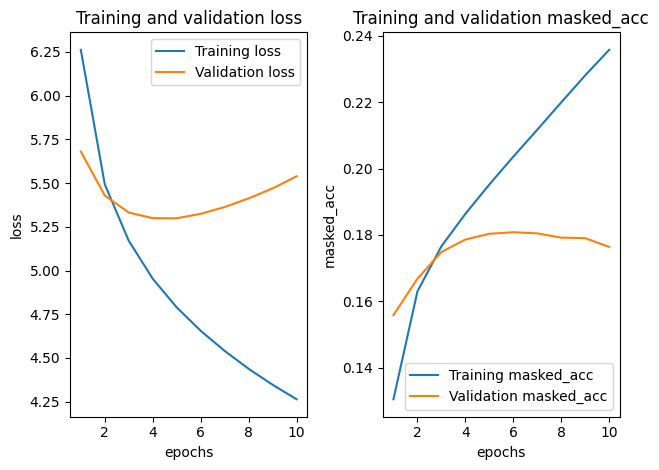

5.298709869384766 The best number of epocs for the validation loss is 5
0.1808236986398697 The best number of epocs for the validation accuracy is 6


In [14]:
# development params to pass running
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 2137 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 256 #  1437 is the longest summarized text in dataset
VOCABULARY_SIZE = 15000
BATCH_SIZE = 16
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 6
INTERMIDIATE_DIM = 512
EMBEDDING_DIM = 64
DECAY_STEPS = 100
DECAY_RATE = 1.0

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMIDIATE_DIM,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
)
plot(history=history)

In [15]:
predict_main(
    filepath=filepath,
    examples=EXAMPLES,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
)

build is called [[None, 2137], [None, 256]]


/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 98 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream l

ORIGINAL SENTENCE:  (CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I'm proud of myself and I'll continue to work to dominate for as long as possible," Bolt said, having previously expressed his intention to carry on until the 2016 Rio Olympics. Vict

## Note

- training-lossは減少傾向、training-accは上昇傾向、valは逆の傾向が見られるのでoverfit傾向にある
- networkのhead,dim,layersを増やして全体の数値が向上するのかみたい
- 逆に数値を減らして全体の数値が劣化することを示しても良いかもしれない（しかし高頻度の語彙があるので下限のborderで止まる可能性もある）
- 翻訳モデルで検証することも可能

The network size seemingly causes this problem. In the larger size neural network of translation model, let us verify.

In [ ]:
model.summary()

***
## Larger model

2024-07-03 18:44:51.608721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


build is called ((None, 2137), (None, 256))
Epoch 1/10


/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefo

1795/1795 ━━━━━━━━━━━━━━━━━━━━ 8087s 4s/step - loss: 6.7994 - masked_acc: 0.1045 - val_loss: 5.7279 - val_masked_acc: 0.1548
Epoch 2/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 5346s 3s/step - loss: 5.6556 - masked_acc: 0.1593 - val_loss: 5.4593 - val_masked_acc: 0.1693
Epoch 3/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 5339s 3s/step - loss: 5.2970 - masked_acc: 0.1745 - val_loss: 5.3666 - val_masked_acc: 0.1744
Epoch 4/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 5318s 3s/step - loss: 5.0724 - masked_acc: 0.1846 - val_loss: 5.3498 - val_masked_acc: 0.1766
Epoch 5/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 5045s 3s/step - loss: 4.9200 - masked_acc: 0.1921 - val_loss: 5.3655 - val_masked_acc: 0.1772
Epoch 6/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 4998s 3s/step - loss: 4.8088 - masked_acc: 0.1983 - val_loss: 5.3888 - val_masked_acc: 0.1771
Epoch 7/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 4970s 3s/step - loss: 4.7210 - masked_acc: 0.2033 - val_loss: 5.4101 - val_masked_acc: 0.1773
Epoch 8/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 4950s 3s/step - l

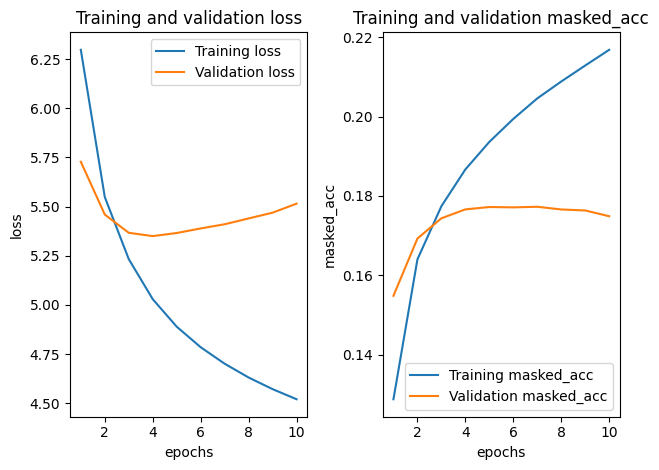

5.349842548370361 The best number of epocs for the validation loss is 4
0.17725861072540283 The best number of epocs for the validation accuracy is 7


In [18]:
# development params to improve acc
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 2137 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 256 #  1437 is the longest summarized text in dataset
VOCABULARY_SIZE = 15000
BATCH_SIZE = 16
NUM_ENCODERS = 2
NUM_DECODERS = 2
NUM_HEADS = 12
INTERMIDIATE_DIM = 1024
EMBEDDING_DIM = 64
DECAY_STEPS = 100
DECAY_RATE = 1.0

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMIDIATE_DIM,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
)
plot(history=history)

In [19]:
predict_main(
    filepath=filepath,
    examples=EXAMPLES,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
)

build is called [[None, 2137], [None, 256]]


/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 182 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream 

ORIGINAL SENTENCE:  (CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I'm proud of myself and I'll continue to work to dominate for as long as possible," Bolt said, having previously expressed his intention to carry on until the 2016 Rio Olympics. Vict

## Note

- The validation loss value got slightly larger.
- The validation accuracy got slightly smaller.
- The loss and accuracy path have not changed at all.

***
## Functional API model

2024-07-04 12:36:44.057674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "transformer_encoder_decoder_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 2137)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 2137, 64)  │  1,096,768 │ encoder_inputs[0… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 256, 64)   │    976,384 │ decoder_inputs[0… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 2137, 64)  │     81,972 │ token_and_positi… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, 256, 64)   │     97,704 │ token_and_positi… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256,       │    975,000 │ transformer_deco… │
│                     │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,227,828 (12.31 MB)

 Trainable params: 3,227,828 (12.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefo

1795/1795 ━━━━━━━━━━━━━━━━━━━━ 932s 514ms/step - loss: 6.7873 - masked_acc: 0.1062 - val_loss: 5.6913 - val_masked_acc: 0.1554
Epoch 2/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 3528s 2s/step - loss: 5.6113 - masked_acc: 0.1581 - val_loss: 5.4459 - val_masked_acc: 0.1666
Epoch 3/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 912s 506ms/step - loss: 5.2509 - masked_acc: 0.1721 - val_loss: 5.3445 - val_masked_acc: 0.1732
Epoch 4/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 912s 506ms/step - loss: 5.0165 - masked_acc: 0.1829 - val_loss: 5.3061 - val_masked_acc: 0.1777
Epoch 5/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 920s 510ms/step - loss: 4.8443 - masked_acc: 0.1919 - val_loss: 5.3042 - val_masked_acc: 0.1795
Epoch 6/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 937s 520ms/step - loss: 4.7059 - masked_acc: 0.2002 - val_loss: 5.3228 - val_masked_acc: 0.1796
Epoch 7/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 988s 548ms/step - loss: 4.5879 - masked_acc: 0.2082 - val_loss: 5.3565 - val_masked_acc: 0.1791
Epoch 8/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 1007s

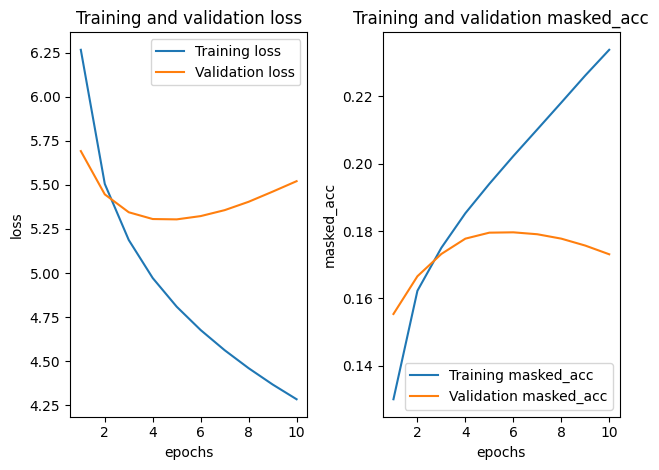

5.304164409637451 The best number of epocs for the validation loss is 5
0.17962834239006042 The best number of epocs for the validation accuracy is 6


In [24]:
# development params to pass running
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 2137 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 256 #  1437 is the longest summarized text in dataset
VOCABULARY_SIZE = 15000
BATCH_SIZE = 16
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 6
INTERMIDIATE_DIM = 512
EMBEDDING_DIM = 64
MASK_ZERO = True
DECAY_STEPS = 100
DECAY_RATE = 1.0

model, filepath, history = build_model_functionally(
    train_ds, validation_ds, test_ds,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMIDIATE_DIM,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
)
plot(history=history)

### Note

Almost nothing changed.

- The shortage decoder sequence length loses correlation?
- The mask zero parameter should be False?

In [27]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 2137 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 1438 #  1437 is the longest summarized text in dataset
VOCABULARY_SIZE = 15000
BATCH_SIZE = 16
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 6
INTERMIDIATE_DIM = 512
EMBEDDING_DIM = 64
MASK_ZERO = False
DECAY_STEPS = 100
DECAY_RATE = 1.0

model, filepath, history = build_model_functionally(
    train_ds, validation_ds, test_ds,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMIDIATE_DIM,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
)
plot(history=history)

2024-07-04 16:02:02.997431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "transformer_encoder_decoder_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 2137)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 1438)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 2137, 64)  │  1,096,768 │ encoder_inputs[0… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 1438, 64)  │  1,052,032 │ decoder_inputs[0… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 2137, 64)  │     81,972 │ token_and_positi… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, 1438, 64)  │     97,704 │ token_and_positi… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1438,      │    975,000 │ transformer_deco… │
│                     │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,303,476 (12.60 MB)

 Trainable params: 3,303,476 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 2536s 1s/step - loss: 6.7911 - masked_acc: 0.1048 - val_loss: 5.7155 - val_masked_acc: 0.1544
Epoch 2/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 2458s 1s/step - loss: 5.6280 - masked_acc: 0.1575 - val_loss: 5.4533 - val_masked_acc: 0.1648
Epoch 3/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 2427s 1s/step - loss: 5.2640 - masked_acc: 0.1712 - val_loss: 5.3684 - val_masked_acc: 0.1719
Epoch 4/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 2484s 1s/step - loss: 5.0416 - masked_acc: 0.1810 - val_loss: 5.3262 - val_masked_acc: 0.1754
Epoch 5/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 9600s 5s/step - loss: 4.8704 - masked_acc: 0.1897 - val_loss: 5.3159 - val_masked_acc: 0.1780
Epoch 6/10
1577/1795 ━━━━━━━━━━━━━━━━━━━━ 5:20 1s/step - loss: 4.7353 - masked_acc: 0.1979

### Note

The performance slightly got worse. There might be a bug.

***

In [ ]:
# minimum viable params
LEARNING_RATE = 0.001
NUM_EPOCHS = 20
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 2137 # @TODO The followings should programmatically be derived.
DECODER_SEQUENCE_LENGTH = 256 #  1437 is the longest summarized text in dataset
VOCABULARY_SIZE = 15000
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 6
INTERMIDIATE_DIM = 512
EMBEDDING_DIM = 64
DECAY_STEPS = 100
DECAY_RATE = 1.0

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMIDIATE_DIM,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
)
plot(history=history)

In [ ]:
predict_main(
    filepath=filepath,
    examples=EXAMPLES,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
)

In [ ]:
# default params
FLAGS_learning_rate = 0.001
FLAGS_num_epochs = 50 # default=1, but too small
FLAGS_steps_per_epoch = None
FLAGS_sequence_length = 20 # Input and output sequence length.
FLAGS_vocab_size = 15000 # Vocabulary size, required by tokenizer.
FLAGS_batch_size = 64
FLAGS_num_encoders = 2
FLAGS_num_decoders = 2
FLAGS_num_heads = 8 # Number of head of the multihead attention.
FLAGS_intermediate_dim = 128 # Intermediate dimension (feedforward network) of transformer.
FLAGS_model_dim = 64
FLAGS_decay_steps = 20
FLAGS_decay_rate = 0.98

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    transformer_intermediate_dim=INTERMIDIATE_DIM,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
)
plot(history=history)

In [ ]:
predict_main(
    filepath=filepath,
    examples=EXAMPLES,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
)